# Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series
- Nama: Ananta Alfallah Tarigan
- Email: anantar437471@gmail.com
- Id Dicoding: ananta_alfallah

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import copy
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

Mempersiapkan data yang ingin digunakan

In [2]:
data = pd.read_csv('jena_climate_2009_2016.csv')
data.drop(data.iloc[:, 3:],axis = 1,inplace=True)
data.drop(columns='p (mbar)',inplace=True)
data.head(3)

,Date Time,T (degC)
0,01.01.2009 00:10:00,-8.02
1,01.01.2009 00:20:00,-8.41
2,01.01.2009 00:30:00,-8.51


In [3]:
df = copy.copy(data)
df.isnull().sum()

Date Time    0
T (degC)     0
dtype: int64

Memfilter data tempratur untuk tahun 2009-2012

In [4]:
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
start_date = pd.to_datetime('2009-01-01')
end_date = pd.to_datetime('2012-12-31')
filtered_df = df[(df['Date Time'] >= start_date) & (df['Date Time'] <= end_date)]

Mengubah sampel tiap menit, menjadi tiap jam

In [5]:
filtered_df.set_index('Date Time', inplace=True)
daily_temperatures = filtered_df['T (degC)'].resample('H').mean()
daily_temperatures_df = daily_temperatures.to_frame(name='temperature')

In [6]:
daily_temperatures_df.info() #berjumlah 35041 data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35041 entries, 2009-01-01 00:00:00 to 2012-12-31 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  35041 non-null  float64
dtypes: float64(1)
memory usage: 547.5 KB


Memplot dataset

<Axes: xlabel='Date Time'>

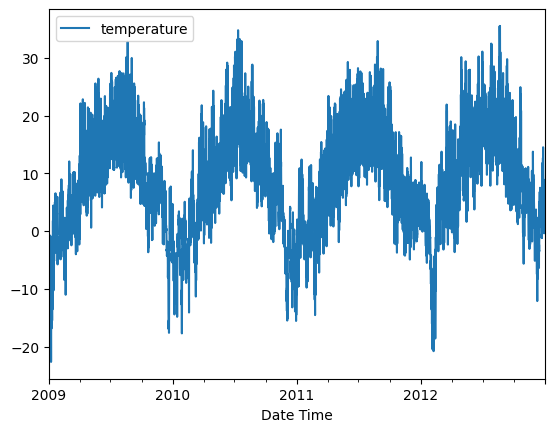

In [7]:
daily_temperatures_df.plot()

In [8]:
daily_temperatures_df.reset_index(inplace=True)
daily_temperatures_df['Date Time'] = daily_temperatures_df['Date Time'].astype(str)
daily_temperatures_df

,Date Time,temperature
0,2009-01-01 00:00:00,-8.304000
1,2009-01-01 01:00:00,-8.065000
2,2009-01-01 02:00:00,-8.763333
3,2009-01-01 03:00:00,-8.896667
4,2009-01-01 04:00:00,-9.348333
...,...,...
35036,2012-12-30 20:00:00,5.540000
35037,2012-12-30 21:00:00,5.873333
35038,2012-12-30 22:00:00,6.046667
35039,2012-12-30 23:00:00,6.488333


Melakukan normalisasi

In [9]:
dataset = daily_temperatures_df.drop(columns=['Date Time'])
min_max_scaler = MinMaxScaler()
dataset = min_max_scaler.fit_transform(dataset)
dataset

array([[0.24664394],
       [0.250752  ],
       [0.23874868],
       ...,
       [0.4933108 ],
       [0.5009024 ],
       [0.5002435 ]])

Melakukan pembagian dataset untuk 20% validasi

In [10]:
latih, test, y_latih, y_test = train_test_split(dataset, dataset, test_size=0.2, shuffle=False) 
# Karena menggunakan 1 fitur saja (temperature), untuk memprediksi target yang juga berupa temprature, train_test_split hanya digunakan untuk membagi dataset
# variabel latih dan y_latih akan bernilai sama, yakni untuk data train (80% awalan data), 
# sedangkan test dan y_test juga bernilai sama tetapi digunakan untuk data validasi (20% akhiran data)

In [11]:
test = test.flatten()
latih = latih.flatten()

In [12]:
print('panjang data train:', len(latih))
print('panjang data validasi:', len(test))

panjang data train: 28032
panjang data validasi: 7009


Menemukan nilai threshold dari mae untuk dataset

In [13]:
threshold_mae = (dataset.max() - dataset.min()) * 10/100
print('min:',dataset.min())
print('max:',dataset.max())
print('threshold_mae:',threshold_mae)

min: 0.0
max: 1.0
threshold_mae: 0.1


Membuat fungsi untuk pembuatan window

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Mempersiapkan train set dan val set dalam bentuk jendela bergulir untuk ukuran 72 jam (3 hari)

In [15]:
train_set = windowed_dataset(latih, window_size=72, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(test, window_size=72, batch_size=100, shuffle_buffer=1000)

In [16]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Membuat nodel sequential dan melatih model

In [17]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [19]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100,validation_data = val_set,callbacks=[early_stopping])

Epoch 1/100
280/280 [==============================] - 24s 73ms/step - loss: 0.0040 - mae: 0.0625 - val_loss: 0.0019 - val_mae: 0.0493
Epoch 2/100
280/280 [==============================] - 18s 65ms/step - loss: 8.0289e-04 - mae: 0.0299 - val_loss: 5.8819e-04 - val_mae: 0.0273
Epoch 3/100
280/280 [==============================] - 18s 66ms/step - loss: 3.2510e-04 - mae: 0.0194 - val_loss: 2.4211e-04 - val_mae: 0.0165
Epoch 4/100
280/280 [==============================] - 18s 65ms/step - loss: 2.1505e-04 - mae: 0.0157 - val_loss: 3.0715e-04 - val_mae: 0.0203
Epoch 5/100
280/280 [==============================] - 18s 65ms/step - loss: 1.4957e-04 - mae: 0.0131 - val_loss: 1.5733e-04 - val_mae: 0.0140
Epoch 6/100
280/280 [==============================] - 18s 66ms/step - loss: 1.1646e-04 - mae: 0.0114 - val_loss: 9.1149e-05 - val_mae: 0.0102
Epoch 7/100
280/280 [==============================] - 19s 66ms/step - loss: 1.0022e-04 - mae: 0.0105 - val_loss: 9.1983e-05 - val_mae: 0.0105
Epoch 8

Ukuran mae untuk train dan val sudah di bawah 10% skala data (<0.1). 

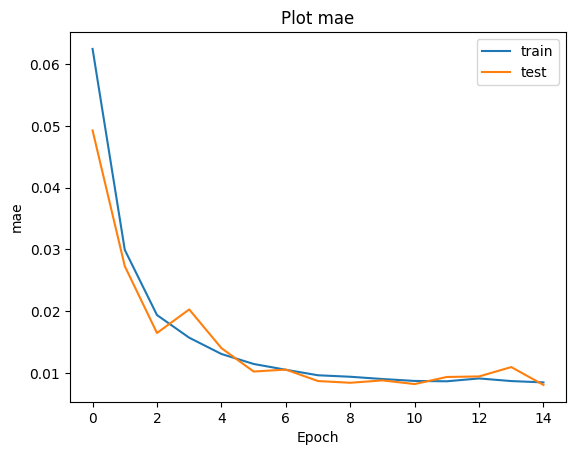

In [20]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Plot mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

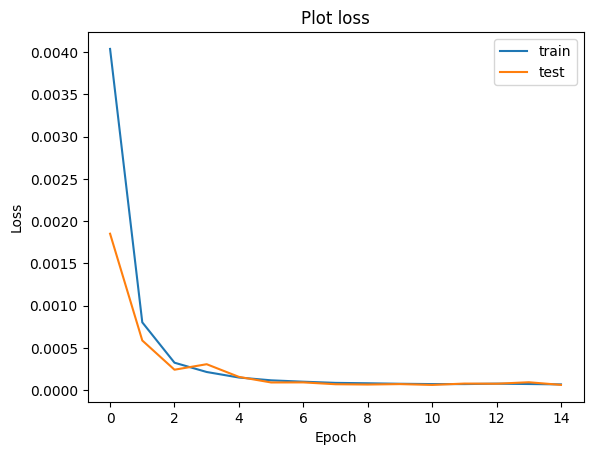

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Mengembalikan ke data prediksi dan data aktual (test), yang ternormalisasi, ke bilangan aslinya

In [22]:
pred = model.predict_generator(val_set)
df_pred = pd.concat([pd.DataFrame(pred).add_prefix('Prediksi'),pd.DataFrame(test[72:]).add_prefix('Aktual')],axis=1)

C:\Users\kocak\AppData\Local\Temp\ipykernel_23292\3411830832.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(val_set)


In [23]:
rev_trans = min_max_scaler.inverse_transform(df_pred)
rev_trans = pd.DataFrame(rev_trans,columns=['Tempratur Prediksi', 'Tempratur Aktual'])
rev_trans

,Tempratur Prediksi,Tempratur Aktual
0,13.719236,7.798333
1,10.252601,6.040000
2,8.771949,5.143333
3,4.353286,4.586667
4,6.738744,3.811667
...,...,...
6932,8.214884,5.540000
6933,8.164218,5.873333
6934,-4.383321,6.046667
6935,0.552171,6.488333


Jumlah row adalah 6937 (bukan seperti panjang data validasi: 7009), dikarenakan penyesuaian dengan hasil prediksi, dimana 72 data awal digunakan untuk nilai input awal